In [100]:
import glob
import os
from random import random

import cv2
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage import measure
from statistics import mode
import scipy.ndimage as nd

from clustimage import Clustimage

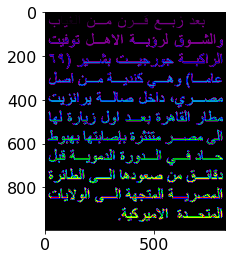

In [109]:
img = cv2.imread("arabic.jpeg", cv2.IMREAD_GRAYSCALE)
thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

(numLabels, labels, stats, centroids) = cv2.connectedComponentsWithStats(thresh)

plt.imshow(labels, cmap='nipy_spectral')

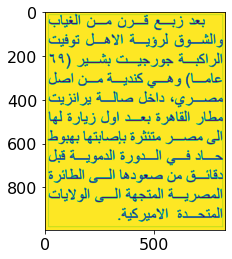

In [110]:
plt.imshow(img)

In [111]:
#Component Extraction

extractedLetters = []

for x in range(1, numLabels):
    output = np.zeros((stats[x][3], stats[x][2]), dtype="uint8")

    for i in range(0, stats[x][3]):
        for j in range(0, stats[x][2]):
            output[i][j] = labels[i + stats[x][1]][j + stats[x][0]]
            
    extractedLetters.append(output)

In [112]:
#Resizing

size = 20

os.mkdir("Resized")

for i in range(0, len(extractedLetters)):
    im = extractedLetters[i]
    old_size = im.shape[:2]
    ratio = float(size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    im = cv2.resize(im, (new_size[1], new_size[0]))

    delta_w = size - new_size[1]
    delta_h = size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
    filename = "Resized/" + str(i) + ".jpg"
    cv2.imwrite(filename, new_im)


In [113]:
# HOG

cl = Clustimage(method='pca', params_pca={'n_components':0.99})
X = cl.import_data("Resized//")
Xfeat = cl.extract_feat(X)


[clustimage] >INFO> Extracting images from: [Resized//]
[clustimage] >INFO> [236] files are collected recursively from path: [Resized//]
[clustimage] >INFO> [236] images are extracted.
[clustimage] >INFO> Reading and checking images.
[clustimage] >WARNING> [C:\Users\ISLAM~1.ANW\AppData\Local\Temp\tmpx4q92b7b] does not exits.
[clustimage] >INFO> Reading and checking images.
100%|███████████████████████████████████████████████████████████████████████████████| 236/236 [00:00<00:00, 474.48it/s]
[clustimage] >INFO> Extracting features using method: [pca]


[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [99.0%] explained variance using the [49152] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [69] that covers the [99.00%] explained variance.
[pca] >The PCA reduction is performed on the [49152] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Extracted features using [pca]: samples=236, features=69


In [114]:
xycoord = cl.embedding(Xfeat)
labels = cl.cluster(cluster='agglomerative', evaluate='silhouette', metric='euclidean', linkage='ward', min_clust=20, max_clust=80, cluster_space='high')
print(cl.results.keys())


[clustimage] >INFO> Compute [tsne] embedding
[clustimage] >INFO> Cluster evaluation using the [high] feature space of the [pca] features.



[clusteval] >Fit using agglomerative with metric: euclidean, and linkage: ward
[clusteval] >Evaluate using silhouette.


100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 372.90it/s]
[clustimage] >INFO> Updating cluster-labels and cluster-model based on the (236, 69) feature-space.


[clusteval] >Compute dendrogram threshold.
[clusteval] >Optimal number clusters detected: [67].
[clusteval] >Fin.
dict_keys(['img', 'feat', 'xycoord', 'pathnames', 'labels', 'filenames'])


(<Figure size 1080x720 with 1 Axes>,
 <AxesSubplot:title={'center':'tsne plot. Samples are coloured on the cluster labels (high dimensional).'}, xlabel='x-axis', ylabel='y-axis'>)

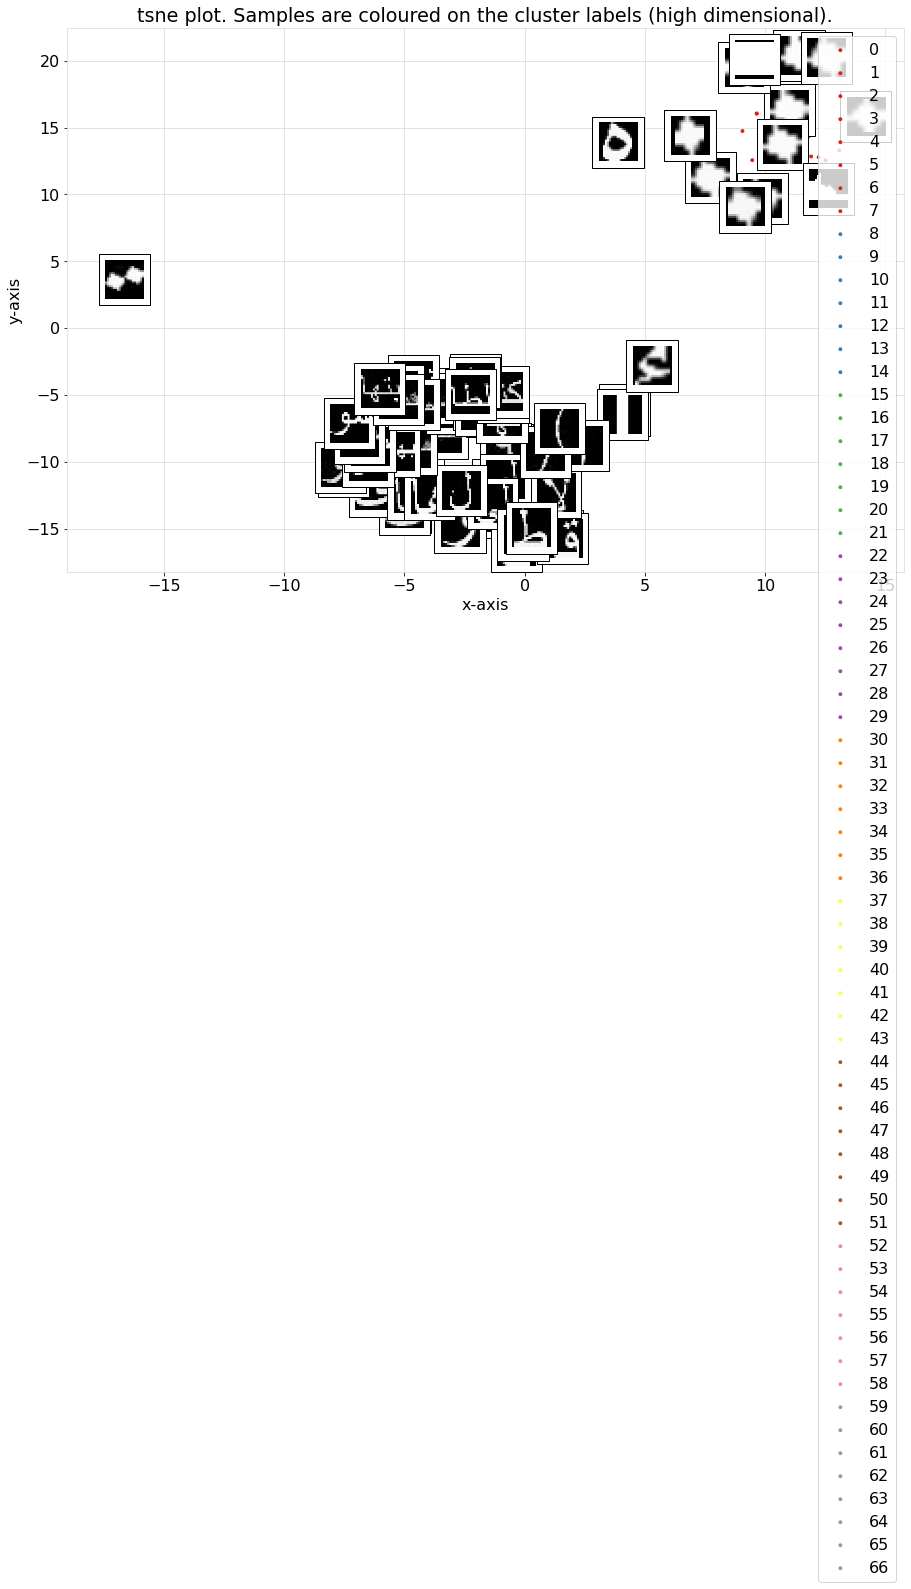

In [115]:
cl.scatter()